# Image Analysis and Processing
## Assignment 2
### Exercise 1

#### Andrinopoulou Christina (ds2200013)
#### Kalimeris Alexandros (ds1200003)

The code for this exercise is based on the code that was provided in the lectures of the course.

In [1]:
# imports needed for the exercise
import cv2
import numpy as np
from matplotlib import pyplot as plt
from scipy import ndimage
import math

In [2]:
def distance(point1,point2):
    return np.sqrt((point1[0]-point2[0])**2 + (point1[1]-point2[1])**2)

def gaussianLP(D0,imgShape):
    base = np.zeros(imgShape[:2])
    rows, cols = imgShape[:2]
    center = (rows/2,cols/2)
    for x in range(cols):
        for y in range(rows):
            base[y,x] = np.exp(((-distance((y,x),center)**2)/(2*(D0**2))))
    return base

def gaus_freq(img):
    original = np.fft.fft2(img)
    center = np.fft.fftshift(original)
    LowPassCenter = center * gaussianLP(50,img.shape)
    LowPass = np.fft.ifftshift(LowPassCenter)
    inverse_LowPass = np.fft.ifft2(LowPass)
    return np.abs(inverse_LowPass)
    

### i)
Firstly, we want to find the main edges of the given image. A really effective and widely used way to achieve that is to use the Canny edge detector. In order for the Canny algorithm to provide the best results, we also need to perform a blurring of the image before applying the algorithm. We will try various ways to blur an image that we saw earlier during the course. 

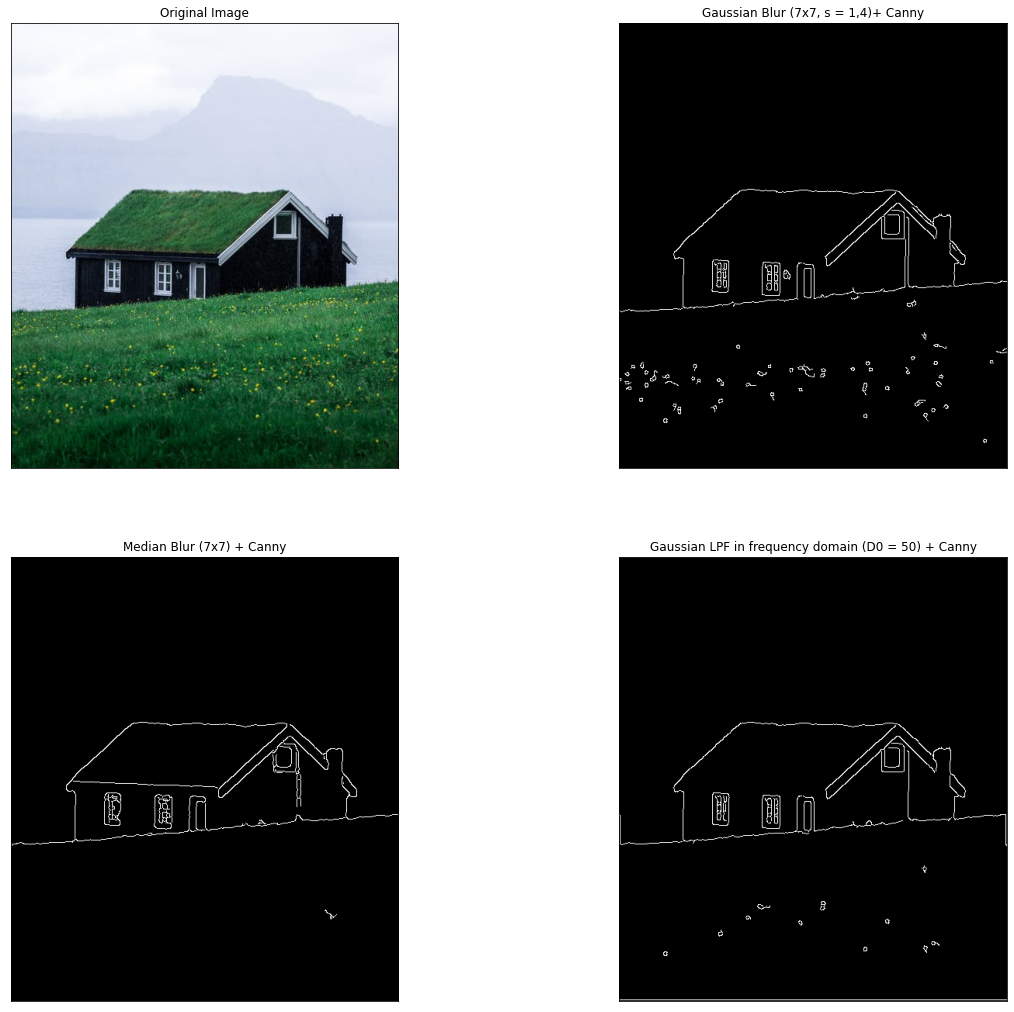

In [3]:
import cv2
import numpy as np

from matplotlib import pyplot as plt

img = cv2.imread('image11.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
img_blur_med = cv2.medianBlur(gray,7)
img_blur_gaus = cv2.GaussianBlur(gray, (7, 7), 0)
img_blur_gfreq = gaus_freq(gray).astype(np.uint8)

#canny
v = np.median(gray)
sigma = 0.5
lower = int(max(0, (1.0 - sigma) * v))
upper = int(min(255, (1.0 + sigma) * v))
img_canny_med = cv2.Canny(img_blur_med, lower, upper)
img_canny_gaus = cv2.Canny(img_blur_gaus, lower, upper)
img_canny_gfreq = cv2.Canny(img_blur_gfreq, lower, upper)
    

fig, axes = plt.subplots(2, 2, figsize=(20,18))

plt.subplot(221),plt.imshow(img, cmap = 'gray')
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.subplot(222),plt.imshow(img_canny_gaus, cmap = 'gray')
plt.title('Gaussian Blur (7x7, s = 1,4)+ Canny'), plt.xticks([]), plt.yticks([])
plt.subplot(223),plt.imshow(img_canny_med, cmap = 'gray')
plt.title('Median Blur (7x7) + Canny'), plt.xticks([]), plt.yticks([])
plt.subplot(224),plt.imshow(img_canny_gfreq, cmap = 'gray')
plt.title('Gaussian LPF in frequency domain (D0 = 50) + Canny'), plt.xticks([]), plt.yticks([])
plt.show()
plt.show()

As we can see in the results above, the Gaussian filtering either in the original or the frequency domain missed a main edge (the big horizontal line at the roof) and where also more noisy than the median filter. Since we need to capture only the main edges we find the Median filter to be the most appropriate.

### ii)
For the second part of this exercise we need to find the angle formed between the diagonal lines of the roof and the horizontal axis. The hough algorithm is really well suited for this task. In order to find the requested angles we will perform the following steps.

- From the previously found edges keep only the diagonal ones. For this we will perform morphological openings with a diagonal and an anti-diagonal kernel and then add the results.
- Then perform the Hough algorithm.
- Using the returned parameter $ \theta $ we can then calculate the angle between the line and the horizontal axis.

After a little bit of parameter tuning we were able to find the lines and the angles and we show the results below.
 

In [4]:
def degree_calc(lines):
    theta = lines[0][0][1]
    return (round(math.degrees(theta))+90)%180

def find_diag_lines(image, edges):
    
    kernel = np.zeros((7,7), dtype=np.uint8)
    np.fill_diagonal(kernel, 1)
    kernel_anti = np.fliplr(kernel)
    img1 = cv2.morphologyEx(edges, cv2.MORPH_OPEN, kernel)
    img2 = cv2.morphologyEx(edges, cv2.MORPH_OPEN, kernel_anti)
    img_final = cv2.add(img1, img2)
    kernel = np.ones((3,3), dtype=np.uint8)
    plt.figure(figsize=(12,10))
    plt.imshow(img_final, cmap = 'gray')
    plt.title('Detected Lines'), plt.xticks([]), plt.yticks([])
    plt.show()
    
    lines = cv2.HoughLines(img_final, 1, 7 * (np.pi/180), 50)
    image_all_lines = image.copy()
    for i, line in enumerate(lines):
        image_tmp = image.copy()
        rho,theta = line[0]
        deg = degree_calc([line])
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a*rho
        y0 = b*rho
        x1 = int(x0 + 1000*(-b))
        y1 = int(y0 + 1000*(a))
        x2 = int(x0 - 1000*(-b))
        y2 = int(y0 - 1000*(a))
        plt.figure(figsize=(12,10))
        cv2.line(image_tmp,(x1,y1),(x2,y2),(255,0,0),2)
        cv2.line(image_all_lines,(x1,y1),(x2,y2),(255,0,0),2)
        plt.imshow(image_tmp)
        plt.title(f'Diagonal Line: {i+1}, angle: {deg}'), plt.xticks([]), plt.yticks([])
        plt.show()
            
    return image_all_lines


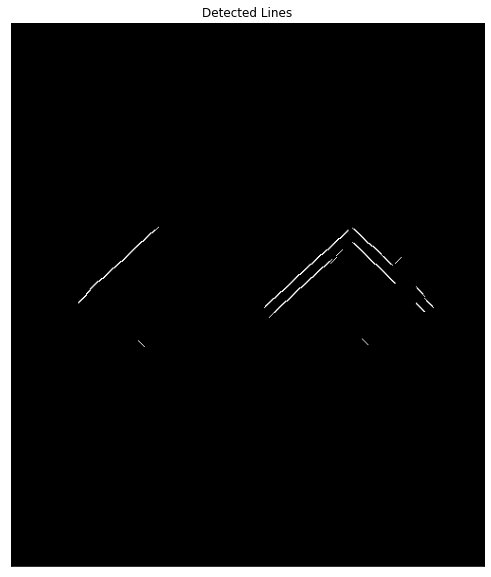

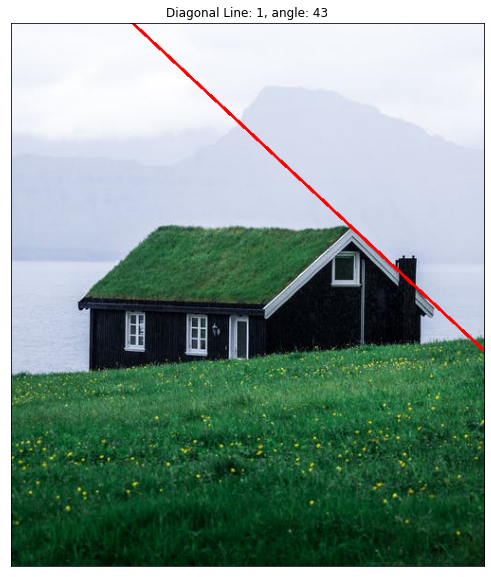

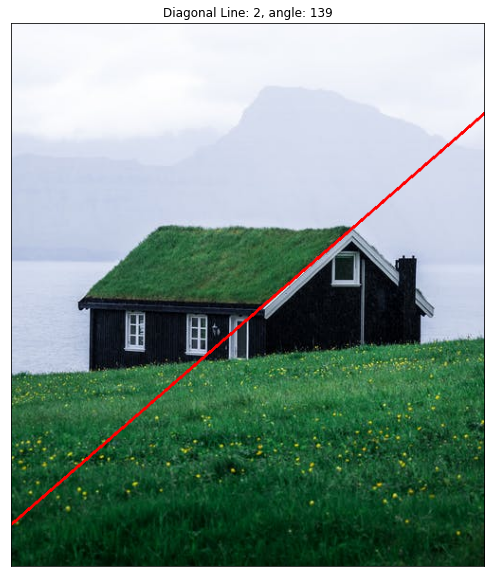

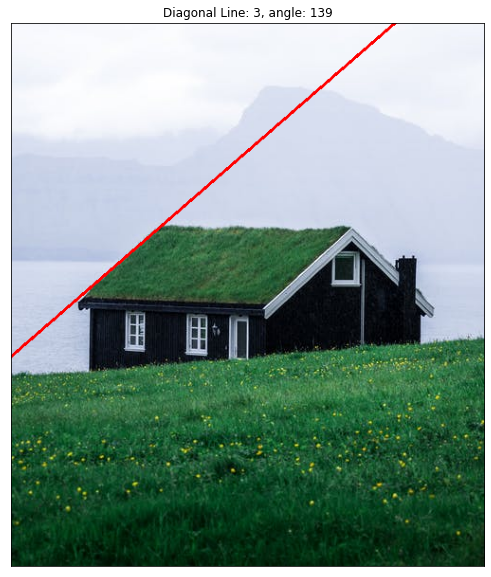

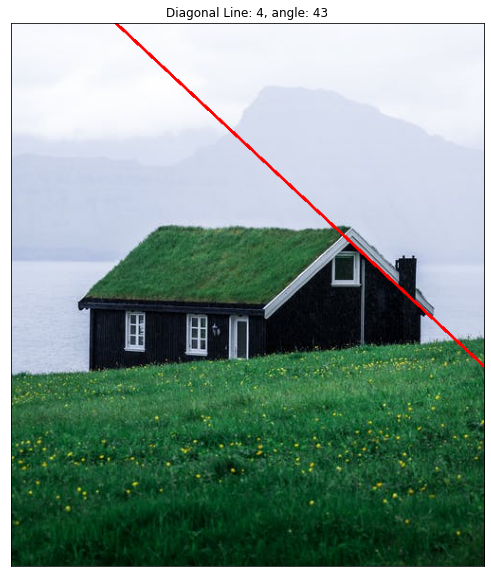

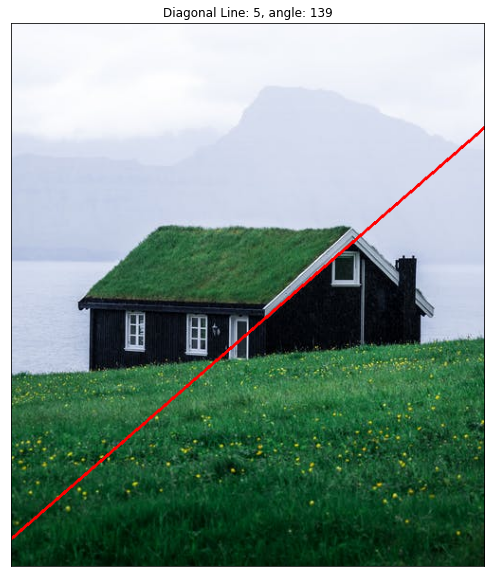

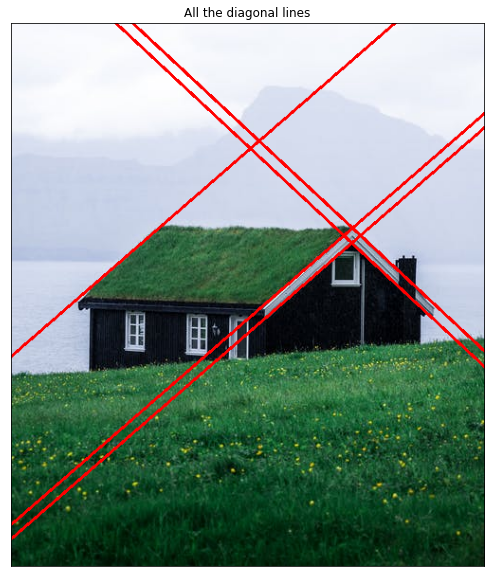

In [5]:
image = find_diag_lines(img, img_canny_med)
plt.figure(figsize = (12,10))
plt.imshow(image), plt.xticks([]), plt.yticks([])
plt.title('All the diagonal lines')
plt.show()

### iii)
Moving on to the third part of the exercise we need to find the corners in the image. This can be achieved by applying the Harris corner detection algorithm to detect those corner points. First we convert the image to grayscale and then we apply a median filter to filter out any noise that would be found as corners. You can see the results by running the code snippet below. 


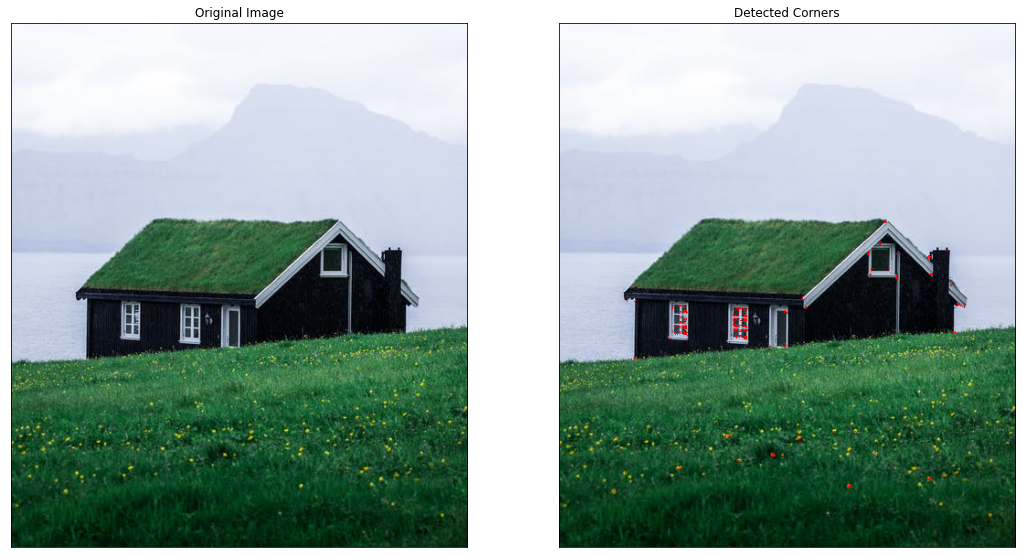

In [17]:
img = cv2.imread('image11.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
gray = cv2.medianBlur(gray, 5)

gray = np.float32(gray)
dst = cv2.cornerHarris(gray,2,3,0.04)
corners = np.zeros(dst.shape).astype(np.float32)
corners[dst>0.01*dst.max()]=1
corners_img = img.copy()
corners_img[corners>0]=[255,0,0]

fig, axes = plt.subplots(1, 2, figsize=(18,16))

plt.subplot(121)
plt.imshow(img, cmap = 'gray')
plt.title('Original Image')
plt.xticks([]), plt.yticks([])
plt.subplot(122)
plt.imshow(corners_img, cmap = 'gray')
plt.title('Detected Corners')
plt.xticks([]), plt.yticks([])
plt.show() 

As expected there is a significant concentration of corners at the points where edges intersect. Especially at the barred windows.

### iv)

Reaching the final part of the exercise, we are asked to locate the windows in the image based on the detected corners. In order to complete this task we are going to use the corners found in the previous part of the exercise in combination with some morphological operations. We will desribe the process we used step by step below.

- Get the edges of the image again with a 5x5 median filter

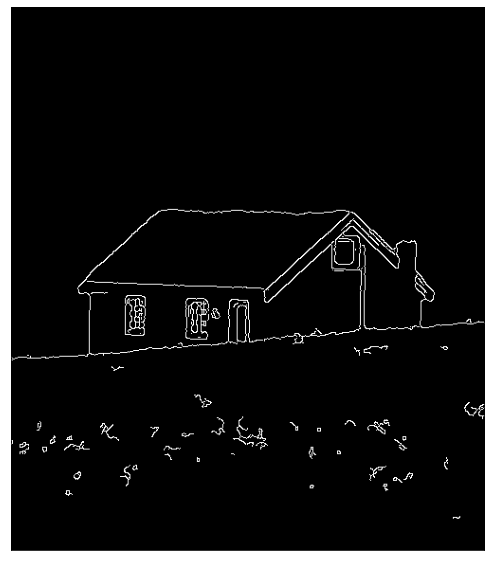

In [18]:
v = np.median(gray)
sigma = 0.5
lower = int(max(0, (1.0 - sigma) * v))
upper = int(min(255, (1.0 + sigma) * v))
gray = gray.astype(np.uint8)
edges = cv2.Canny(gray, lower, upper)
plt.figure(figsize=(12,10))
plt.imshow(edges, cmap = 'gray')
plt.xticks([]), plt.yticks([])
plt.show()

- Apply morphological opening on the edges (with a diagonal and an anti-diagonal kernel) and then subtract the result from the edges in order to remove the diagonal edges since they are not needed to identify the windows.

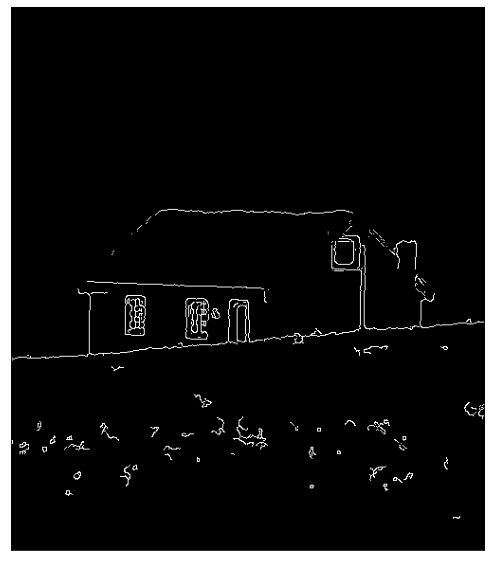

In [19]:
kernel = np.zeros((7,7), dtype=np.uint8)
np.fill_diagonal(kernel, 1)
kernel_anti = np.fliplr(kernel)
img1 = cv2.morphologyEx(edges, cv2.MORPH_OPEN, kernel)
img2 = cv2.morphologyEx(edges, cv2.MORPH_OPEN, kernel_anti)
img_final = cv2.add(img1, img2)
edges = cv2.subtract(edges, img_final)

plt.figure(figsize=(12,10))
plt.imshow(edges, cmap = 'gray')
plt.xticks([]), plt.yticks([])
plt.show()

- In order to keep the areas that are the corners are mostly concentrated perform a dilation followed by an opening. 
- This way at the places with high corner concentration, after dilation dense surfaces will be formed. On the other areas there will be sparsely spaced dilated corners that will be removed by an opening

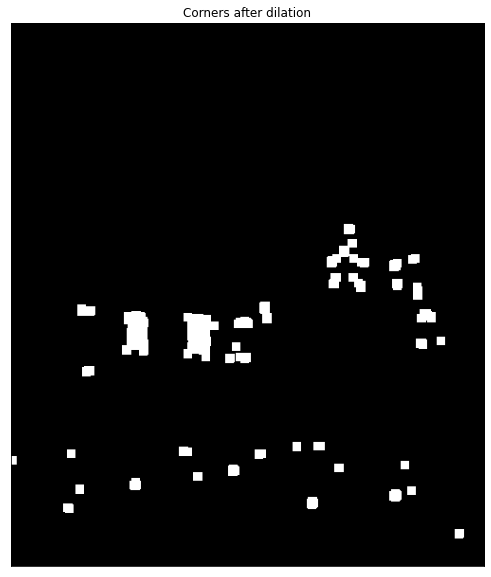

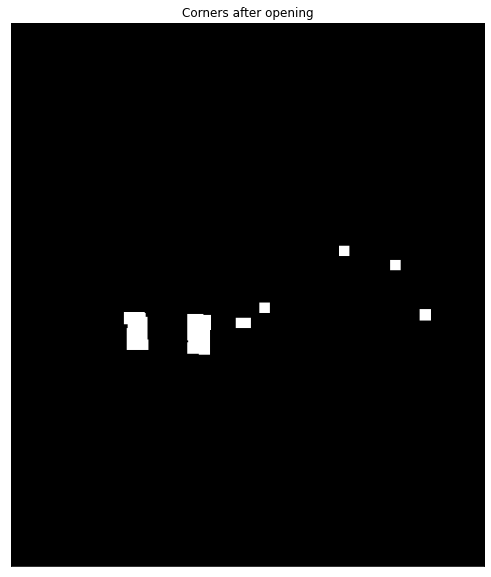

In [21]:
kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(9, 9))
corners_m = cv2.dilate(corners,kernel,iterations = 1)
plt.figure(figsize=(12,10))
plt.imshow(corners_m, cmap = 'gray')
plt.title('Corners after dilation')
plt.xticks([]), plt.yticks([])
plt.show() 

kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(11, 11))
corners_m = cv2.morphologyEx(corners_m, cv2.MORPH_OPEN, kernel)
plt.figure(figsize=(12,10))
plt.imshow(corners_m, cmap = 'gray')
plt.title('Corners after opening')
plt.xticks([]), plt.yticks([])
plt.show() 

- By applying morphological reconstruction we can reconstruct the edges that are mainly around the areas with corner concentration. The function used is defined in the cell below.

In [22]:
def imreconstruct(marker, mask, radius = 1, iterations = 10):
    i = 1
    kernel = np.ones(shape=(radius * 2 + 1, radius * 2 + 1), dtype=np.uint8)
    while True:
        expanded = cv2.dilate(src=marker, kernel=kernel)
        cv2.bitwise_and(src1=expanded, src2=mask, dst=expanded)
        if i >= iterations:
            return expanded

        # Termination criterion: Expansion didn't change the image at all
        if (marker == expanded).all():
            return expanded
        marker = expanded
        i += 1

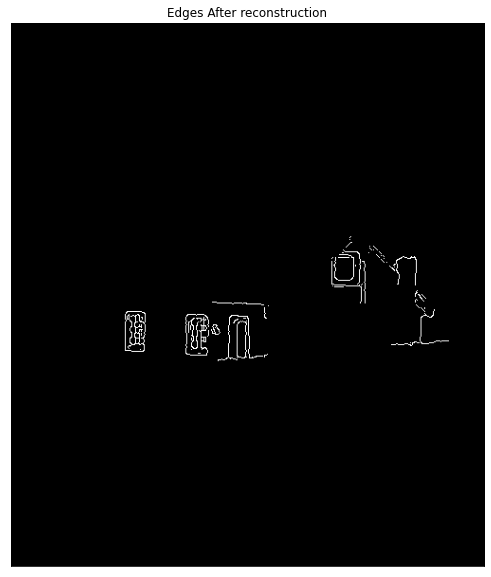

In [23]:
edges_recon = imreconstruct(corners_m.astype(np.uint8), edges, 5)
plt.figure(figsize=(12,10))
plt.imshow(edges_recon, cmap = 'gray')
plt.title('Edges After reconstruction')
plt.xticks([]), plt.yticks([])
plt.show() 

- Now by applying a small dilation to make sure the borders of the square areas (windows) connect. Then we can use the fill_holes function from ndimage to fill those square areas and form the surfaces that represent the windows
- Then erode with the same kernel as the dilation to revert the effects of dilation after we filled the square objects.
- Then apply a morphological opening with a 9x9 kernel to remove thin lines and small patches.
- Finally apply a morphological closing to smothen out any small irregularities on the border or small holes.

In [24]:
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3, 3))
edges_recon = cv2.dilate(edges_recon,kernel,iterations = 1)
edges_recon = ndimage.binary_fill_holes(edges_recon).astype(np.uint8)
edges_recon = cv2.erode(edges_recon,kernel,iterations = 1)

kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(7, 7))
edges_recon = cv2.morphologyEx(edges_recon, cv2.MORPH_OPEN, kernel)

kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(9, 9))
edges_recon = cv2.morphologyEx(edges_recon, cv2.MORPH_CLOSE, kernel)

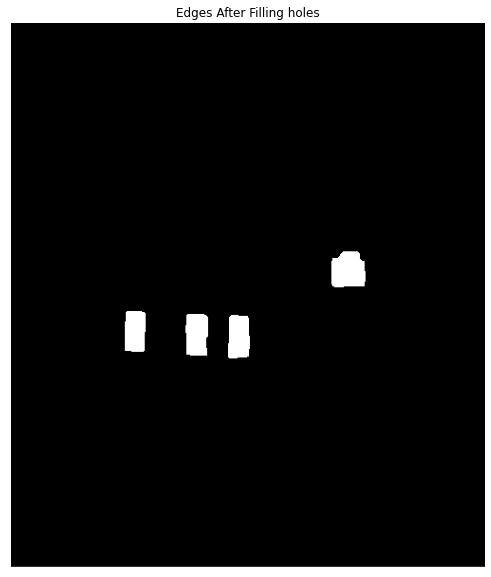

In [25]:
plt.figure(figsize=(12,10))
plt.imshow(edges_recon, cmap = 'gray')
plt.title('Edges After Filling holes')
plt.xticks([]), plt.yticks([])
plt.show() 

- Show the results on the original image.

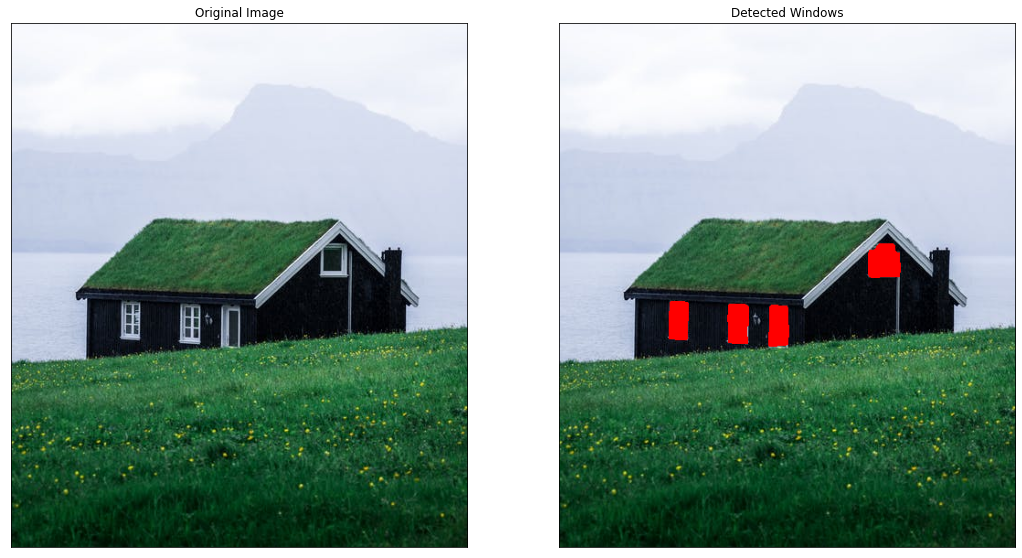

In [26]:
fig, axes = plt.subplots(1, 2, figsize=(18,16))
windows_img = img.copy()
windows_img[edges_recon>0]=[255,0,0]
plt.subplot(121)
plt.imshow(img, cmap = 'gray')
plt.title('Original Image')
plt.xticks([]), plt.yticks([])
plt.subplot(122)
plt.imshow(windows_img, cmap = 'gray')
plt.title('Detected Windows')
plt.xticks([]), plt.yticks([])
plt.show() 

If we consider the rectangle object, that on in the same side of the house as the 2 barred windows, a door. We can remove it by using the Connected Components with stats OpenCV function.

In [27]:
connectivity = 4  
output = cv2.connectedComponentsWithStats(edges_recon, connectivity, cv2.CV_32S)
num_labels = output[0]
labels = output[1]
stats = output[2]
centroids = output[3]


- Now by using the stats provided, especially the height over width ratio, we can remove the "door object".

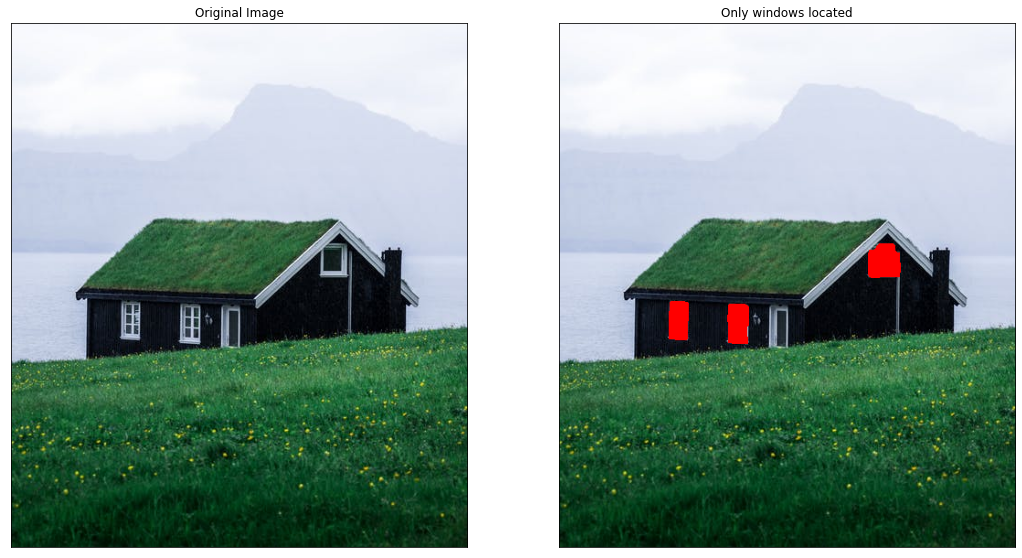

In [28]:
heights = stats[:, -2]
widths = stats[:, -3]

max_label = 1
max_ratio = heights[1]/widths[1]
for i in range(2, num_labels):
    ratio = heights[i]/widths[i]
    if ratio > max_ratio:
        max_label = i
        max_size = ratio
labels = np.where(labels == max_label, 0, labels)
windows_only = np.where(labels > 0, 255, 0)
windows_only_img = img.copy()
windows_only_img[windows_only>0]=[255,0,0]

fig, axes = plt.subplots(1, 2, figsize=(18,16))
plt.subplot(121)
plt.imshow(img, cmap = 'gray')
plt.title('Original Image')
plt.xticks([]), plt.yticks([])
plt.subplot(122)
plt.imshow(windows_only_img, cmap = 'gray')
plt.title('Only windows located')
plt.xticks([]), plt.yticks([])
plt.show() 